In [1]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer, AutoModel
import torch
from torch import Tensor
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt

# Оценка энкодеров по метрике Accuracy@5

In [2]:
dataset = load_dataset('medical_questions_pairs')
data = dataset['train'].to_pandas()

In [3]:
print(f"Всего вопросов в question_1: {len(data)}")
print(f"Кол-во уникальных вопросов в question_1: {data['question_1'].nunique()}")

print(f"Список вариантов, сколько лэйблов может быть у question_1: {data.groupby('question_1').agg(count = ('question_1', 'count'))['count'].unique()}")

Всего вопросов в question_1: 3048
Кол-во уникальных вопросов в question_1: 1524
Список вариантов, сколько лэйблов может быть у question_1: [2]


У каждого вопроса в question_1 есть ровно два разных лэйбла

In [4]:
print(f"Кол-во уникальных вопросов в question_2: {data['question_2'].nunique()}")
# У 4 вопросов из question_2 есть дубли (у одного вопроса два дубля), при этом у всех лэйблы 0, поэтому в оценке точности эти вопросы учитывать не будем
print("Дублирующиеся записи")
data[~data.index.isin(data[['question_2', 'label']].drop_duplicates().index)]


Кол-во уникальных вопросов в question_2: 3043
Дублирующиеся записи


,dr_id,question_1,question_2,label
72,1,I'm taking anxiety and depression medicine to ...,Can CBT be used to treat anxiety?,0
107,1,What is the cleanest/safest SSRI for general s...,Why do I have anxiety when I go in an elevator?,0
313,2,I have been taking my birthcontrol Amethia for...,I missed my pills for 2 days in a row... Can I...,0
333,2,I messed up my birth control and started a new...,I missed my pills for 2 days in a row... Can I...,0
374,2,I've had a cold for 1week. I just stopped anti...,How is Strep throat diagnosed? Do I need to se...,0


In [5]:
# Проверка, есть ли вопросы, встречающиеся в обоих столбцах.
set(data['question_1']) & set(data['question_2'])

set()

In [156]:
# Сделаем так, чтобы в столбце question_1 были все предложения. Для question_2 с лэйблом 1 мы также будет искать похожие из общего списка.
corpus = pd.concat([data[['question_1', 'question_2', 'label']], data.rename(
    columns={'question_1':'question_2', 'question_2':'question_1'})[['question_2', 'question_1', 'label']]]).drop_duplicates().reset_index(drop=True)

In [155]:
unique_questions = corpus['question_1'].unique()
label_1_questions = corpus[corpus['label']==1]['question_1'].values
print(f"Всего {len(unique_questions)} уникальных вопросов")
print(f"Вопросов, у которых есть label 1: {len(label_1_questions)}")

Всего 4567 уникальных вопросов
Вопросов, у которых есть label 1: 3048


Нужно для каждого из 3048 вопросов найти топ-5 схожих из общего списка 4567 вопросов, не учитывая в общем списке сам вопрос.

Нет смысла оценивать вопросы, у которых есть только лэйбл 0, так как точность на таком вопросе всегда будет равна 0.

In [133]:
# Функция, вычисляющая Accuracy@N
def topn_accuracy(cosine_scores_matrix: Tensor, n=5) -> float:
    # Первое значение всегда 1, так как сравниваем с этим же предложением, поэтому , берем n+1
    _, top_indices = torch.topk(cosine_scores_matrix, k=n+1)
    top_indices = top_indices[:,1:]
    cnt = 0
    for i, top in enumerate(top_indices):
        # Текст вопроса
        question_1 = label_1_questions[i]
        # Список близких вопросов
        question_2_list = unique_questions[list(np.array(top))]
        # Фильтруем собраный датафрейм по первому вопросу (в столбце 1) и списку вопросов (в столбце 2). Если находится пара с лэйблом 1, то и сумма по лэйблу будет = 1
        cnt += corpus[(corpus['question_1']==question_1)&(corpus['question_2'].isin(question_2_list))]['label'].sum()
    # Возвращаем долю вопросов, у которых среди подобранных пар есть лэйбл 1
    return cnt / len(label_1_questions)

metrics = {}

# SentenceTransformer("all-MiniLM-L6-v2")

In [134]:
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings_l1 = model.encode(label_1_questions, show_progress_bar=True)
embeddings_unq = model.encode(unique_questions, show_progress_bar=True)

cosine_scores = torch.tensor(cosine_similarity(embeddings_l1, embeddings_unq))
metrics['all-MiniLM-L6-v2'] = topn_accuracy(cosine_scores)

Batches:   0%|          | 0/96 [00:00<?, ?it/s]

Batches:   0%|          | 0/143 [00:00<?, ?it/s]

In [135]:
metrics

{'all-MiniLM-L6-v2': 0.9635826771653543}

### То же самое проделаем используя только Pytorch (без батчей)


In [137]:
# Получим такой же результат, но фрэймворк SentenceTransformer удобнее и быстрее, не нужно отдельно прописывать разделение на батчи
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

encoded_input_1 = tokenizer(
    list(label_1_questions), padding=True, truncation=True, max_length=128, return_tensors="pt"
)
encoded_input_2 = tokenizer(
    list(unique_questions), padding=True, truncation=True, max_length=128, return_tensors="pt"
)

with torch.no_grad():
    model_output_1 = model(**encoded_input_1)

sentence_embeddings_1 = mean_pooling(model_output_1, encoded_input_1["attention_mask"])

with torch.no_grad():
    model_output_2 = model(**encoded_input_2)

sentence_embeddings_2 = mean_pooling(model_output_2, encoded_input_2["attention_mask"])

cosine_scores = torch.tensor(cosine_similarity(sentence_embeddings_1, sentence_embeddings_2))
pytorch_MiniLM = topn_accuracy(cosine_scores)
pytorch_MiniLM

0.9635826771653543

Получаем такой же результат. Далее будет использовать SentenceTransformer

# SentenceTransformer("paraphrase-MiniLM-L6-v2")

In [138]:
model = SentenceTransformer("paraphrase-MiniLM-L6-v2")
embeddings_l1 = model.encode(label_1_questions, show_progress_bar=True)
embeddings_unq = model.encode(unique_questions, show_progress_bar=True)

cosine_scores = torch.tensor(cosine_similarity(embeddings_l1, embeddings_unq))
metrics['paraphrase-MiniLM-L6-v2'] = topn_accuracy(cosine_scores)

Batches:   0%|          | 0/96 [00:00<?, ?it/s]

Batches:   0%|          | 0/143 [00:00<?, ?it/s]

In [139]:
metrics

{'all-MiniLM-L6-v2': 0.9635826771653543,
 'paraphrase-MiniLM-L6-v2': 0.9235564304461942}

# SentenceTransformer("all-mpnet-base-v2")

In [140]:
model = SentenceTransformer("all-mpnet-base-v2")
embeddings_l1 = model.encode(label_1_questions, show_progress_bar=True)
embeddings_unq = model.encode(unique_questions, show_progress_bar=True)

cosine_scores = torch.tensor(cosine_similarity(embeddings_l1, embeddings_unq))
metrics['all-mpnet-base-v2'] = topn_accuracy(cosine_scores)

Batches:   0%|          | 0/96 [00:00<?, ?it/s]

Batches:   0%|          | 0/143 [00:00<?, ?it/s]

In [141]:
metrics

{'all-MiniLM-L6-v2': 0.9635826771653543,
 'paraphrase-MiniLM-L6-v2': 0.9235564304461942,
 'all-mpnet-base-v2': 0.9681758530183727}

# SentenceTransformer("all-MiniLM-L12-v2")

In [142]:
model = SentenceTransformer("all-MiniLM-L12-v2")
embeddings_l1 = model.encode(label_1_questions, show_progress_bar=True)
embeddings_unq = model.encode(unique_questions, show_progress_bar=True)

cosine_scores = torch.tensor(cosine_similarity(embeddings_l1, embeddings_unq))
metrics['all-MiniLM-L12-v2'] = topn_accuracy(cosine_scores)

Batches:   0%|          | 0/96 [00:00<?, ?it/s]

Batches:   0%|          | 0/143 [00:00<?, ?it/s]

In [143]:
metrics

{'all-MiniLM-L6-v2': 0.9635826771653543,
 'paraphrase-MiniLM-L6-v2': 0.9235564304461942,
 'all-mpnet-base-v2': 0.9681758530183727,
 'all-MiniLM-L12-v2': 0.9586614173228346}

# TfidfVectorizer

In [150]:
# Посчитаем с использованием стоп-слов
vectorizer = TfidfVectorizer(stop_words='english')
vector_1 = vectorizer.fit_transform(label_1_questions)
vector_2 = vectorizer.transform(unique_questions)

cosine_scores = torch.tensor(cosine_similarity(vector_1, vector_2))
metrics['TfidfVectorizer_stopwords'] = topn_accuracy(cosine_scores)

# Посчитаем без использования стоп-слов
vectorizer = TfidfVectorizer()
vector_1 = vectorizer.fit_transform(label_1_questions)
vector_2 = vectorizer.transform(unique_questions)

cosine_scores = torch.tensor(cosine_similarity(vector_1, vector_2))
metrics['TfidfVectorizer'] = topn_accuracy(cosine_scores)

In [151]:
metrics

{'all-MiniLM-L6-v2': 0.9635826771653543,
 'paraphrase-MiniLM-L6-v2': 0.9235564304461942,
 'all-mpnet-base-v2': 0.9681758530183727,
 'all-MiniLM-L12-v2': 0.9586614173228346,
 'TfidfVectorizer_stopwords': 0.8490813648293963,
 'TfidfVectorizer': 0.8559711286089239}

# CountVectorizer()

In [152]:
# Посчитаем с использованием стоп-слов
vectorizer = CountVectorizer(stop_words='english')
vector_1 = vectorizer.fit_transform(label_1_questions)
vector_2 = vectorizer.transform(unique_questions)

cosine_scores = torch.tensor(cosine_similarity(vector_1, vector_2))
metrics['CountVectorizer_stopwords'] = topn_accuracy(cosine_scores)

# Посчитаем без использования стоп-слов
vectorizer = CountVectorizer()
vector_1 = vectorizer.fit_transform(label_1_questions)
vector_2 = vectorizer.transform(unique_questions)

cosine_scores = torch.tensor(cosine_similarity(vector_1, vector_2))
metrics['CountVectorizer'] = topn_accuracy(cosine_scores)

In [153]:
metrics

{'all-MiniLM-L6-v2': 0.9635826771653543,
 'paraphrase-MiniLM-L6-v2': 0.9235564304461942,
 'all-mpnet-base-v2': 0.9681758530183727,
 'all-MiniLM-L12-v2': 0.9586614173228346,
 'TfidfVectorizer_stopwords': 0.8490813648293963,
 'TfidfVectorizer': 0.8559711286089239,
 'CountVectorizer_stopwords': 0.797244094488189,
 'CountVectorizer': 0.5636482939632546}

# Итоги

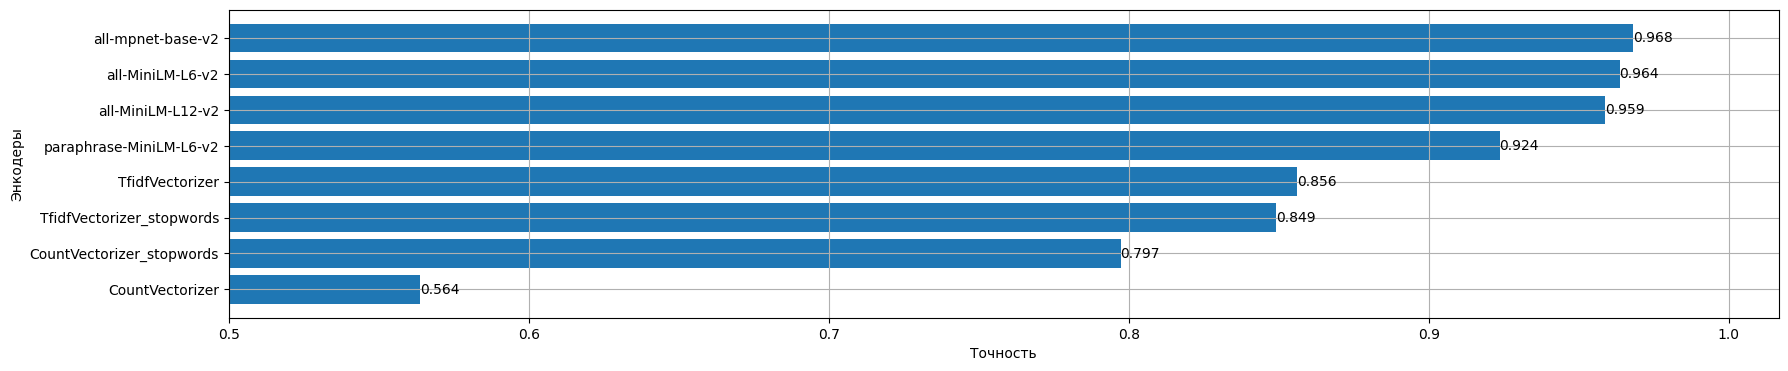

In [154]:
metrics_sorted = dict(sorted(metrics.items(), key=lambda item: item[1]))
plt.figure(figsize=(20, 4))
plt.barh(list(metrics_sorted.keys()), list(metrics_sorted.values()))
plt.xlabel('Точность')
plt.ylabel('Энкодеры')
for i, v in enumerate(metrics_sorted.values()):
    plt.text(v, i, str(round(v,3)), ha='left', va='center')
plt.xlim(0.5)
plt.grid()
plt.show()

Эмбэдинги, полученные на основе токенизаторов предобученных моделей (рассматривались модели, которые обучались на парах предложений) показывают себя заметно лучше классических методов.

Разница между лидерами топ-3 подходов минимальная, для приложения буду использовать all-MiniLM-L6-v2, так как она практически не уступает лучшей модели, но при этом является наиболее легковесной и быстрой.